In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('ggplot')

sys.path.append("src")

from optimization.grid_search import ParameterGridSearch 
from optimization.model_optimization import ProfileOptimizer, ModelParameterOptimizer
from model.semi_batch import SemiBatchReactor
from optimization.utils import build_F

gs = ParameterGridSearch(lb=[0.15, 0.15], ub=[0.5, 0.6], N = 50)
model_ideal = SemiBatchReactor()
model = SemiBatchReactor(k=[0.053, 0.128, 0.0, 0.0, 5])

In [2]:
# Get the fixed model inputs
# TODO: read from DB
opt = ProfileOptimizer()
_, F, _ = opt.run(model)
samples = model_ideal.GetSamples(F, [0.95,0.97,0.99], noise=False)
samples_noisy = model_ideal.GetSamples(F, [0.95,0.97,0.99], noise=True)

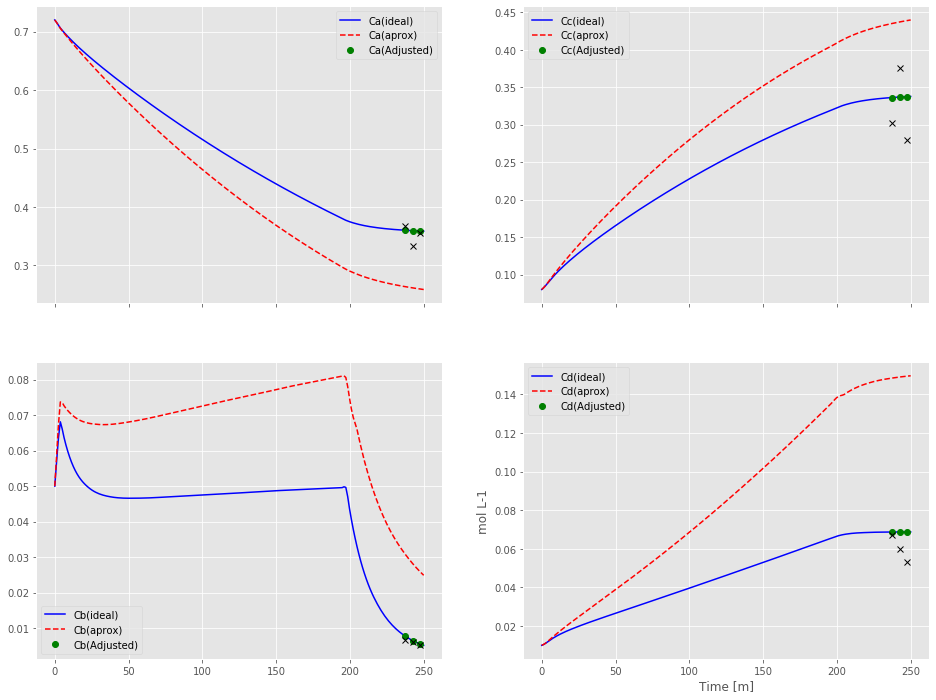

In [3]:
# Plot the process information
# Simulate the solution found
sim_ideal = model_ideal.simulate(F)
sim_aprox = model.simulate(F)

# Build the input signal F
F_ideal = build_F(sim_ideal.t, F)
F_aprox = build_F(sim_aprox.t, F)

# Plot the optimal simulation profiles
fig, (ax1, ax2) = plt.subplots(2, 2, sharex=True, figsize=(16,12))

ax1[0].plot(sim_ideal.t, sim_ideal.y[0], 'b')
ax1[0].plot(sim_aprox.t, sim_aprox.y[0], 'r--')
ax1[0].plot(np.array(list(samples.keys())) * 250, np.array(list(samples.values()))[:,0], 'go')
ax1[0].plot(np.array(list(samples_noisy.keys())) * 250, np.array(list(samples_noisy.values()))[:,0], 'kx')
ax1[0].legend(['Ca(ideal)','Ca(aprox)','Ca(Adjusted)'])

ax1[1].plot(sim_ideal.t, sim_ideal.y[2], 'b')
ax1[1].plot(sim_aprox.t, sim_aprox.y[2], 'r--')
ax1[1].plot(np.array(list(samples.keys())) * 250, np.array(list(samples.values()))[:,2], 'go')
ax1[1].plot(np.array(list(samples_noisy.keys())) * 250, np.array(list(samples_noisy.values()))[:,2], 'kx')
ax1[1].legend(['Cc(ideal)','Cc(aprox)','Cc(Adjusted)'])

ax2[0].plot(sim_ideal.t, sim_ideal.y[1], 'b')
ax2[0].plot(sim_aprox.t, sim_aprox.y[1], 'r--')
ax2[0].plot(np.array(list(samples.keys())) * 250, np.array(list(samples.values()))[:,1], 'go')
ax2[0].plot(np.array(list(samples_noisy.keys())) * 250, np.array(list(samples_noisy.values()))[:,1], 'kx')
ax2[0].legend(['Cb(ideal)','Cb(aprox)','Cb(Adjusted)'])

ax2[1].plot(sim_ideal.t, sim_ideal.y[3], 'b')
ax2[1].plot(sim_aprox.t, sim_aprox.y[3], 'r--')
ax2[1].plot(np.array(list(samples.keys())) * 250, np.array(list(samples.values()))[:,3], 'go')
ax2[1].plot(np.array(list(samples_noisy.keys())) * 250, np.array(list(samples_noisy.values()))[:,3], 'kx')
ax2[1].legend(['Cd(ideal)','Cd(aprox)','Cd(Adjusted)'])

plt.xlabel('Time [m]')
plt.ylabel('mol L-1')
plt.show()


In [4]:
# Run grid search
grid, results, pareto = gs.run(model, F, samples)
grid_noisy, results_noisy, pareto_noisy = gs.run(model, F, samples_noisy)

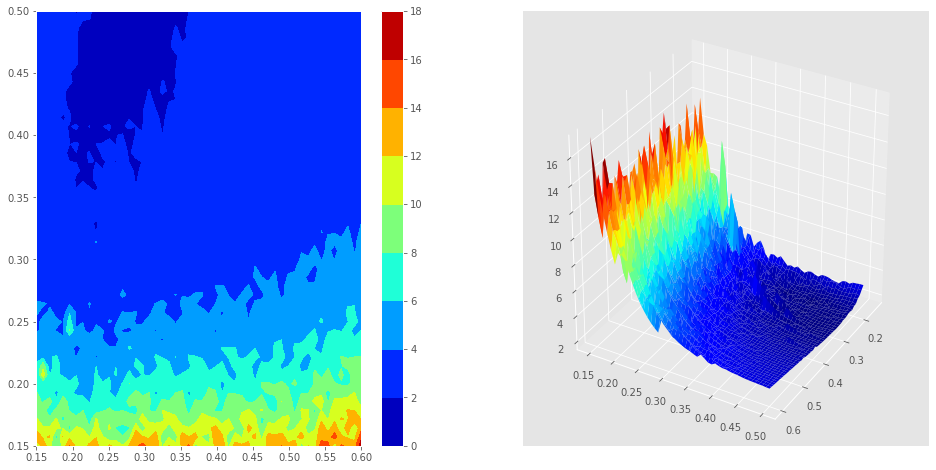

In [5]:
# Plot the grid search results
for key in grid.keys():
    fig = plt.figure(figsize=(16,8))
    plt.subplot(121)
    X, Y = grid[key]
    Z = results[key]
    cs = plt.contourf(X,Y,Z,cmap='jet')
    fig.colorbar(cs)
    
    # ax = fig.add_subplot(122, projection='3d')
    # ax.plot_wireframe(X,Y,Z)

    ax = fig.add_subplot(122, projection='3d')
    ax.view_init(30, 30)
    ax.plot_surface(X,Y,Z,cmap='jet')

plt.show()

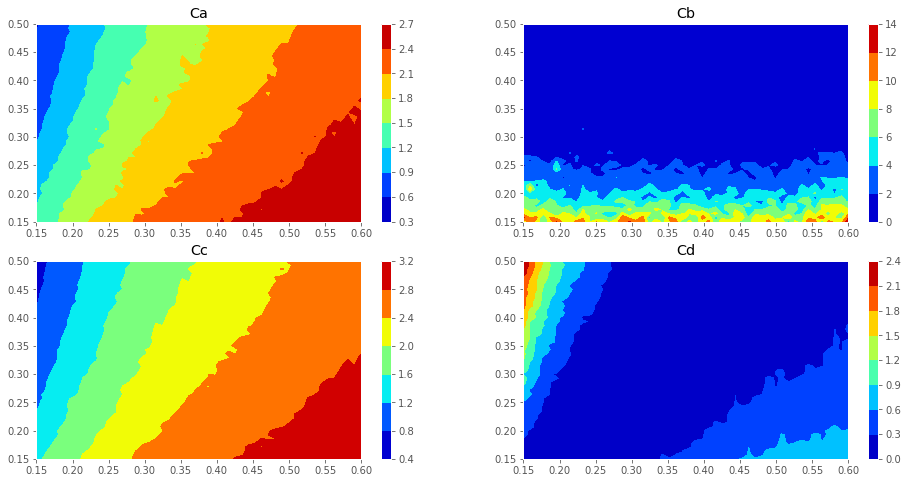

In [39]:
## Plot the pareto fronts
for key in grid.keys():
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,8))
    ax1, ax2, ax3, ax4 = axes.flat
    X, Y = grid[key]
    Z_Ca, Z_Cb, Z_Cc, Z_Cd, Z_V = gs.unpack_errors(pareto[key])
    
    cs = ax1.contourf(X,Y,Z_Ca,cmap='jet')    
    cs2 = ax2.contourf(X,Y,Z_Cb,cmap='jet')
    cs3 = ax3.contourf(X,Y,Z_Cc,cmap='jet')
    cs4 = ax4.contourf(X,Y,Z_Cd,cmap='jet')
    
    ax1.set_title('Ca')
    ax2.set_title('Cb')
    ax3.set_title('Cc')
    ax4.set_title('Cd')
    
    fig.colorbar(cs, ax = ax1)
    fig.colorbar(cs2, ax = ax2)
    fig.colorbar(cs3, ax = ax3)
    fig.colorbar(cs4, ax = ax4)

    #fig.subplots_adjust(right=0.8)
    #cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    #fig.colorbar(cs, cax=cbar_ax)

    plt.show()

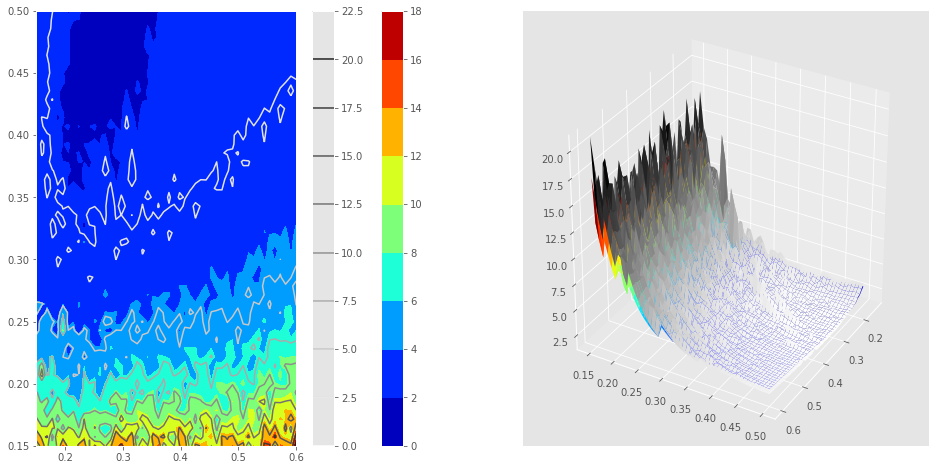

In [6]:
# Compare the noisy and ideal surfaces
for key in grid.keys():
    fig = plt.figure(figsize=(16,8))
    plt.subplot(121)
    X, Y = grid[key]
    
    Z = results[key]
    Z_noisy = results_noisy[key]

    cs = plt.contourf(X,Y,Z,cmap='jet')
    csn = plt.contour(X,Y,Z_noisy,cmap='binary')
    fig.colorbar(cs)
    fig.colorbar(csn)
    
    ax = fig.add_subplot(122, projection='3d')
    ax.view_init(30, 30)
    ax.plot_surface(X,Y,Z,cmap='jet')
    ax.plot_surface(X,Y,Z_noisy,cmap='binary')

plt.show()

In [7]:
# Optimize the model parameters
cal = ModelParameterOptimizer(lb=[0.15, 0.15], ub=[0.5, 0.6])
model_cal = SemiBatchReactor(k=[0.053, 0.128, 0.0, 0.0, 5])
_, x_cal, _ = cal.run(model_cal, F, samples)
_, x_cal_noisy, _ = cal.run(model_cal, F, samples_noisy)
model_adjusted = SemiBatchReactor(k=[x_cal[0], x_cal[1], 0, 0, 5])

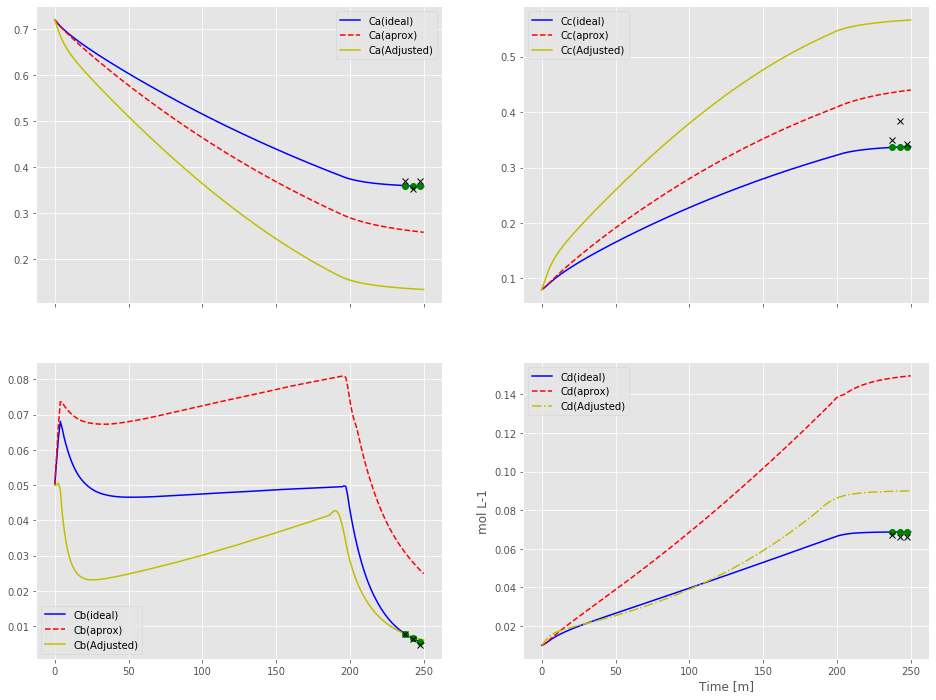

In [8]:
# Plot the process curves after adjustment
# Simulate the solution found
sim_adjusted = model_adjusted.simulate(F)

# Plot the optimal simulation profiles
fig, (ax1, ax2) = plt.subplots(2, 2, sharex=True,figsize=(16,12))

ax1[0].plot(sim_ideal.t, sim_ideal.y[0], 'b')
ax1[0].plot(sim_aprox.t, sim_aprox.y[0], 'r--')
ax1[0].plot(sim_adjusted.t, sim_adjusted.y[0], 'y-')
ax1[0].plot(np.array(list(samples.keys())) * 250, np.array(list(samples.values()))[:,0], 'go')
ax1[0].plot(np.array(list(samples_noisy.keys())) * 250, np.array(list(samples_noisy.values()))[:,0], 'kx')
ax1[0].legend(['Ca(ideal)','Ca(aprox)','Ca(Adjusted)'])

ax1[1].plot(sim_ideal.t, sim_ideal.y[2], 'b')
ax1[1].plot(sim_aprox.t, sim_aprox.y[2], 'r--')
ax1[1].plot(sim_adjusted.t, sim_adjusted.y[2], 'y-')
ax1[1].plot(np.array(list(samples.keys())) * 250, np.array(list(samples.values()))[:,2], 'go')
ax1[1].plot(np.array(list(samples_noisy.keys())) * 250, np.array(list(samples_noisy.values()))[:,2], 'kx')
ax1[1].legend(['Cc(ideal)','Cc(aprox)','Cc(Adjusted)'])

ax2[0].plot(sim_ideal.t, sim_ideal.y[1], 'b')
ax2[0].plot(sim_aprox.t, sim_aprox.y[1], 'r--')
ax2[0].plot(sim_adjusted.t, sim_adjusted.y[1], 'y-')
ax2[0].plot(np.array(list(samples.keys())) * 250, np.array(list(samples.values()))[:,1], 'go')
ax2[0].plot(np.array(list(samples_noisy.keys())) * 250, np.array(list(samples_noisy.values()))[:,1], 'kx')
ax2[0].legend(['Cb(ideal)','Cb(aprox)','Cb(Adjusted)'])

ax2[1].plot(sim_ideal.t, sim_ideal.y[3], 'b')
ax2[1].plot(sim_aprox.t, sim_aprox.y[3], 'r--')
ax2[1].plot(sim_adjusted.t, sim_adjusted.y[3], 'y-.')
ax2[1].plot(np.array(list(samples.keys())) * 250, np.array(list(samples.values()))[:,3], 'go')
ax2[1].plot(np.array(list(samples_noisy.keys())) * 250, np.array(list(samples_noisy.values()))[:,3], 'kx')
ax2[1].legend(['Cd(ideal)','Cd(aprox)','Cd(Adjusted)'])

plt.xlabel('Time [m]')
plt.ylabel('mol L-1')
plt.show()